## Семинар 6: "Архитектуры и transfer learning"

ФИО: Каспарьянц Георгий Григорьевич

In [9]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision import models
from skimage import io, transform
import pandas as pd
import os
from skimage import io
import time
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

На этом семинаре мы попробуем улучшить результаты, полученные на занятии номер 3 с помощью Transfer Learning

In [2]:
models.AlexNet().features

Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
)

In [3]:
models.AlexNet()

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

### Часть 1: Inference

Пропустите картинки с лицами через предобученную на Imagenet "сверточную часть" AlexNet или VGG сетей и обучите на полученных данных один полносвязный слой.

In [4]:
class Rescale(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample[0], sample[1]
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        return img, landmarks
    
class MyDataset(Dataset):
    alexnet = models.AlexNet().features
    def __init__(self, csv_file, root_dir):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.resc = Rescale((227, 227))
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def getImage(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx, 0])
        image = io.imread(img_name) / 255.0
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        image, landmarks = self.resc((image, landmarks))
        
        return image, landmarks
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx, 0])
        image = io.imread(img_name) / 255.0
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        image, landmarks = self.resc((image, landmarks))
        image = np.tile(image, (3, 1)).reshape([3] + list(image.shape))
        image = image.reshape([1]+list(image.shape))
        image, landmarks = torch.FloatTensor(image), torch.FloatTensor(landmarks.reshape(-1))
        new_data = MyDataset.alexnet(Variable(image))
        return new_data.view(-1).data, landmarks

In [5]:
dataset = MyDataset('./dataset/train/face_landmarks.csv', './dataset/train/')
test_dataset = MyDataset('./dataset/test/face_landmarks.csv', './dataset/test/')
ret = dataset[0]
print(ret[0].shape, ret[1].shape)

torch.Size([9216]) torch.Size([136])


In [6]:
model = nn.Sequential(nn.Linear(9216, 136))
loss_fn = nn.MSELoss()

In [8]:
opt = torch.optim.Adam(lr=0.05, params=model.parameters())
epoch = 8
batch_size = 100
losses = []
test_losses = []
loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
test_loader = iter(DataLoader(test_dataset, shuffle=True, batch_size=batch_size))
x = Variable()
y = Variable()
t = 0

for ep in range(epoch):
    for batch, label in loader:
        x = Variable(batch)
        y = Variable(label)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        if t % 10 == 0:
            losses.append(loss.data.numpy()[0])
            print(t, losses[-1])
        t += 1
        opt.zero_grad()
        loss.backward()
        opt.step()
        if t % 10 == 0:
            batch, label = next(test_loader)
            x_t = Variable(batch)
            y_t = Variable(label)
            y_pred_t = model(x_t)
            loss_t = loss_fn(y_pred_t, y_t)
            test_losses.append(loss_t.data.numpy()[0])
            
            
        

0 17293.0
10 8431.23
20 3502.79
30 1194.9
40 587.763
50 368.421
60 267.351
70 290.3
80 263.804
90 264.767
100 267.198
110 242.04
120 266.372
130 243.835
140 269.242
150 234.156
160 239.82


StopIteration: 

Обучение было сперва с lr = 0.1
на шаге 15 было замененено на lr= 0.01 и прообучалось еще 5 шагов
шаг - t += 10

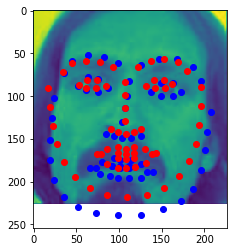

In [10]:
img, lands = dataset.getImage(0)
img_pass, _ = dataset[0]
preds = model(Variable(img_pass)).data.numpy().reshape((68, 2))

plt.imshow(img)
plt.scatter(lands[:, 0], lands[:,1], c='b')
plt.scatter(preds[:, 0], preds[:,1], c='r')
plt.show()

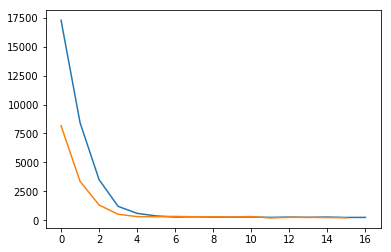

In [11]:
plt.plot(losses)
plt.plot(test_losses)
plt.show()
# train loss

### Часть 2 (опциональная)

Попробуйте обучить одну из архитектур на датасете. Сравните результаты с пунктом 1  

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: